# 生成mask

In [28]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18,ResNet18_Weights
from torchcam.methods import SmoothGradCAMpp

model = resnet18(weights='DEFAULT').eval()
# Get your input
img = read_image("./111.png")
# Preprocess it for your chosen model
input_tensor = normalize(
    resize(img, (224, 224)) / 255.0, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
)

with SmoothGradCAMpp(model) as cam_extractor:
    # Preprocess your data and feed it to the model
    out = model(input_tensor.unsqueeze(0))
    # Retrieve the CAM by passing the class index and the model output
    activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

In [44]:
import torch
def get_mask(image, classifiermodel, threshold=0.5):
    input_tensor = normalize(
        resize(image, (224, 224)) / 255.0,
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225],
    )
    cam_extractor=SmoothGradCAMpp(classifiermodel,'layer4',num_samples=16)
    # Preprocess your data and feed it to the model
    out = classifiermodel(input_tensor.unsqueeze(0))
    # Retrieve the CAM by passing the class index and the model output
    activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
    # print(type(activation_map[0]))
    activation_map=activation_map[0]
    activation_map = torch.where(activation_map > threshold, activation_map, torch.tensor(0.0).to(activation_map.device))  # 将小于阈值的权重设为 0

    return activation_map

amap=get_mask(img, model,  threshold=0.5)

In [46]:
amap
amap.shape

torch.Size([1, 7, 7])

In [58]:
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.transforms import InterpolationMode
mask = resize(amap,(224,224),interpolation=InterpolationMode.BICUBIC)
mask

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

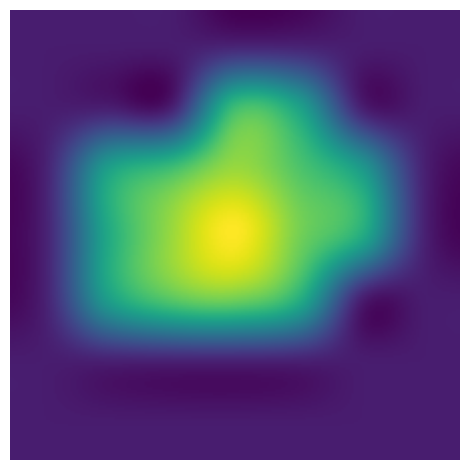

In [59]:
import matplotlib.pyplot as plt
# Visualize the raw CAM
plt.imshow(X=mask.squeeze(0).numpy()); plt.axis('off'); plt.tight_layout(); plt.show()

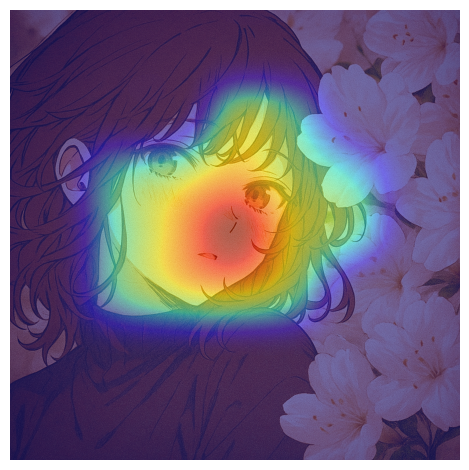

In [60]:
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask

# Resize the CAM and overlay it
result = overlay_mask(to_pil_image(img), to_pil_image(mask.squeeze(0), mode='F'), alpha=0.5)
# Display it
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

In [ ]:
import torch

def cam_weight_mask(tensor, precent):
    """
    保留张量中前百分比大小的权重。

    参数:
        tensor (torch.Tensor): 输入张量。
        百分比 (float): 要保留的权重的百分比 (例如, 50.0 表示 50%)。

    返回值:
        torch.Tensor: 经过处理的张量，其中较小的权重被设置为 0。
    """
    # 1. 将张量展平为一维张量
    flat_tensor = tensor.flatten()

    # 2. 计算阈值
    k = int(precent * flat_tensor.numel())
    threshold = torch.topk(flat_tensor.abs(), k).values[-1]

    # 3. 应用阈值
    mask = flat_tensor.abs() >= threshold
    new_tensor = tensor.clone()
    new_tensor[tensor.abs() < threshold] = 0

    return new_tensor

# 示例用法
weights = activation_map[0]

# 保留前 50% 的权重
new_weights = cam_weight_mask(weights, 0.3)
print(new_weights)

In [ ]:
result = overlay_mask(to_pil_image(img), to_pil_image(new_weights[0].squeeze(0), mode='F'), alpha=0.5)
# Display it
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

# 将图像转换到隐空间
1. 获取到diffusion模型
2. 使用q_sample转换到隐空间指定步数
3. 使用ddim_sample进行降噪还原

# 尝试整个攻击流程

In [18]:
# 导入必要的库
import torch
import numpy as np
from PIL import Image
# 假设您已经加载了 diffusion, model, classifier 等

# 1. 生成随机噪声并保存
def generate_and_save_noise(image_size, device):
    """生成随机噪声并保存到变量中."""
    noise = torch.randn(1, 3, image_size, image_size, device=device)
    return noise

# 2. 对噪声进行去噪，获得最终的去噪样本
def denoise(noise, diffusion, model, steps, device):
    """对噪声进行去噪，返回去噪后的样本."""
    sample = diffusion.p_sample_loop(
        model,
        shape=noise.shape,
        noise=noise,
        clip_denoised=True,
        progress=True,
        device=device,
    )
    return sample

# 3. 使用 SmoothGradCAMpp 获得去噪结果的特征图
def get_smooth_grad_campp(sample, classifier, target_class):
    """使用 SmoothGradCAMpp 获得去噪结果的特征图."""
    # 这里需要您自己实现 SmoothGradCAMpp 的代码
    # 可以参考相关的库，例如 pytorch-gradcam
    # 示例代码（需要根据您的具体实现进行调整）：
    # from pytorch_gradcam import SmoothGradCAMPlusPlus
    # cam = SmoothGradCAMPlusPlus(model=classifier, target_layer=classifier.layer4[-1]) # 假设 layer4 是目标层
    # grayscale_cam = cam(input_tensor=sample, target_category=target_class)
    # return grayscale_cam
    print("请在这里实现 SmoothGradCAMpp 代码")
    return None

# 4. 重新开始去噪，并在第 40 步进行攻击
def denoise_with_attack(noise, diffusion, model, steps, device, attack_step=40):
    """重新开始去噪，并在指定步骤进行攻击."""
    original_noise = noise.clone()  # 保存原始噪声
    sample = original_noise
    for i in range(steps):
        t = torch.tensor([steps - i - 1], device=device)
        with torch.no_grad():
            model_output = model(sample, t)
            pred = diffusion.p_sample(
                model_output,
                sample,
                t,
                clip_denoised=True,
                repeat_noise=False,
            )
            sample = pred["sample"]

        if i == attack_step:
            print("执行攻击操作！")
            # 在这里执行攻击操作，例如调用 attack 函数
            # attack(sample, ...)  # 替换为您的攻击函数
            pass  # 占位符，替换为实际的攻击代码

    return sample



In [19]:
from guided_diffusion.script_util import (
    NUM_CLASSES,
    model_and_diffusion_defaults,
    classifier_defaults,
    create_model_and_diffusion,
    create_classifier,
    add_dict_to_argparser,
    args_to_dict,
)
from argparse import Namespace


def get_imagenet_dm_conf(
    class_cond=False,
    respace="",
    device="cpu",
    model_path="./model/256x256_diffusion_uncond.pt",
):

    defaults = dict(
        clip_denoised=True,
        num_samples=10000,
        batch_size=16,
        use_ddim=False,
    )

    model_config = dict(
        use_fp16=False,
        attention_resolutions="32, 16, 8",
        class_cond=class_cond,
        diffusion_steps=1000,
        image_size=256,
        learn_sigma=True,
        noise_schedule="linear",
        num_channels=256,
        num_head_channels=64,
        num_res_blocks=2,
        resblock_updown=True,
        use_scale_shift_norm=True,
        timestep_respacing=respace,
    )

    defaults.update(model_and_diffusion_defaults())
    defaults.update(model_config)
    args = Namespace(**defaults)

    model, diffusion = create_model_and_diffusion(
        **args_to_dict(args, model_and_diffusion_defaults().keys())
    )


    # load ckpt

    ckpt = torch.load(model_path,map_location='cpu')
    model.load_state_dict(ckpt)
    model = model.to(device)


    return model, diffusion


In [ ]:

# 设置参数
image_size = 256  # 图像大小
device = "cuda" if torch.cuda.is_available() else "cpu"
num_diffusion_steps = 100  # 扩散步数
target_class = 282  # 目标类别 (根据您的分类器调整)

model, diffusion = get_imagenet_dm_conf(
        device=device, respace="ddim50", model_path="model/256x256_diffusion_uncond.pt"
    )

# 1. 生成并保存噪声
noise = generate_and_save_noise(image_size, device)

# 2. 第一次去噪
denoised_sample = denoise(noise.clone(), diffusion, model, num_diffusion_steps, device)

# # 3. 获取 SmoothGradCAMpp 特征图
# heatmap = get_smooth_grad_campp(denoised_sample, classifier, target_class)
# if heatmap is not None:
#     print("SmoothGradCAMpp 特征图已生成")

# # 4. 第二次去噪，并在第 40 步进行攻击
# attacked_sample = denoise_with_attack(
#     noise.clone(), diffusion, model, num_diffusion_steps, device, attack_step=40
# )
# print("攻击后的样本已生成")

# print("流程完成！")

In [ ]:
denoised_sample2 = denoise(noise.clone(), diffusion, model, num_diffusion_steps, device)


In [ ]:
   # 图像显示
# 假设 denoised_sample 的形状是 (1, 3, 256, 256)
out = denoised_sample[0]  # 取出第一个样本，形状变为 (3, 256, 256)

# 调整维度顺序，将 (C, H, W) 转换为 (H, W, C)
out = np.transpose(out, (1, 2, 0))

plt.imshow(out)  # 显示图像
plt.title("Denoised Sample")
plt.axis('off')  # 关闭坐标轴
plt.show()

In [ ]:
   # 图像显示
# 假设 denoised_sample 的形状是 (1, 3, 256, 256)
out = denoised_sample2[0]  # 取出第一个样本，形状变为 (3, 256, 256)

# 调整维度顺序，将 (C, H, W) 转换为 (H, W, C)
out = np.transpose(out, (1, 2, 0))

plt.imshow(out)  # 显示图像
plt.title("Denoised Sample")
plt.axis('off')  # 关闭坐标轴
plt.show()

# 测试callback函数

目的：
1. 修改latents
    这可以 `从callback_kwargs["latents"]` 获得

2. 进行攻击
    1. 需要使用mask
        先固定噪声，保存下来，进行一边去噪
        获得最终结果后，生成对应的mask
        随后再使用保存下来的噪声再次进行去噪
    2. 去噪到一定阶段后开始进行攻击
        需要使用callback函数
        需要使用分类器
        需要区分是（对隐函数进行攻击/对当前阶段去噪后的图像进行攻击）
            前者可以用guided-diffusion中的分类器
            后者可以使用正常resnet系列之类的
        

In [ ]:
def interrupt_callback(pipeline, i, t, callback_kwargs):
    attack_idx = 30
    if i >= attack_idx:
        latents = callback_kwargs["latents"]
        # 1. 读取mask文件
        mask=0
        
        #2. 将图像转变成分类器能够识别的数据
        denoise_img=latents
        
        #3. 使用分类器计算梯度
        def cal_grade(image,classify):
            pass
        
        
        #4. 使用梯度计算攻击样本
        def gen_attack_sample():
            pass
        
        #5. 结合mask，将攻击样本与原始latents进行结合
        
        latents[:, :, 0:8, 56:64] = 0
        callback_kwargs["latents"]=latents
        # print(latents.shape)


    return callback_kwargs

In [16]:
import torch

torch.randn(3,3)

tensor([[ 0.3367,  0.1288,  0.2345],
        [ 0.2303, -1.1229, -0.1863],
        [ 2.2082, -0.6380,  0.4617]])

In [17]:
torch.randn(3,3)

tensor([[ 0.2674,  0.5349,  0.8094],
        [ 1.1103, -1.6898, -0.9890],
        [ 0.9580,  1.3221,  0.8172]])

In [18]:
torch.randn(3,3)

tensor([[-0.7658, -0.7506,  1.3525],
        [ 0.6863, -0.3278,  0.7950],
        [ 0.2815,  0.0562,  0.5227]])